In [1]:
from math import ceil
import numpy as np
from dragonn.models import SequenceDNN
import matplotlib.pyplot as plt
import gzip

%matplotlib inline

SEQ_LEN = 145
STRIDE  = 29

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5005)
/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [8]:
model = SequenceDNN.load('../models/models/100n1_100n2_8w1_15w2.arch.json',
                         '../models/models/100n1_100n2_8w1_15w2.weights.h5')

In [2]:
def fragment_seq(seq):
    center = ceil(len(seq) / 2)
    shifts = int((center - SEQ_LEN / 2) / STRIDE)
    seqs = []
    for i in range(-shifts, shifts + 1):
        start = int(center + i*STRIDE - SEQ_LEN / 2)
        end   = int(center + i*STRIDE + SEQ_LEN / 2 + 1)
        
        seqs += [seq[start:end].upper()]
    return seqs


bases = ['A', 'T', 'C', 'G']

def one_hot_encode_seq(seq):
    if "N" in seq:
        seq = seq.replace("N", "A")
    result = np.zeros((len(bases), len(seq)))
    for i, base in enumerate(seq):
        result[bases.index(base), i] = 1
    return result
    
def seqs_to_encoded_matrix(seqs):
    # Wrangle the data into a shape that Dragonn wants.
    result = np.concatenate(
        map(one_hot_encode_seq, seqs)
    ).reshape(
        len(seqs), 1, len(bases), len(seqs[0])
    )
    
    # Check we actually did the encoding right.
    for i in range(len(seqs)):
        for j in range(len(seqs[0])):
            assert sum(result[i, 0, :, j]) == 1
            
    return result

In [5]:
seqs, coords = [], []
with gzip.open('/mnt/dnase/hepg2.dnase.fa.gz') as dnase:
    chrom = None
    for line in dnase:
        if line[0] == '>':
            if chrom:
                frags = fragment_seq(seq)
                seqs += frags
                coords += [(chrom, start, end, len(frags))]
            count, rest = line[1:].strip().split('::')
            chrom, rest = rest.split(':')
            start, end = map(int, rest.split('-'))
            seq = ''
        else:
            seq += line.strip()

In [24]:
X1 = seqs_to_encoded_matrix(seqs[:15 * 10000])
pred1 = model.predict(X1)
pred2 = model.predict(seqs_to_encoded_matrix(seqs[15 * 10000: 15 * 20000]))
pred3 = model.predict(seqs_to_encoded_matrix(seqs[15 * 40000: 15 * 50000]))

In [47]:
pred4 = model.predict(seqs_to_encoded_matrix(seqs[15 * 80000: 15 * 90000]))


In [53]:
pred5 = model.predict(seqs_to_encoded_matrix(seqs[15 * 180000: 15 * 190000]))

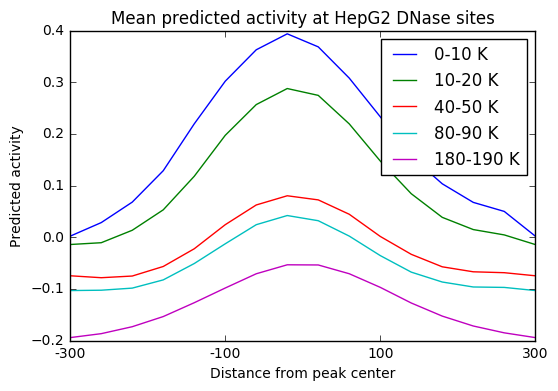

In [55]:
plt.plot([pred1[range(i, pred1.shape[0], 15), 0].mean() for i in range(16)], label = "0-10 K")
plt.plot([pred2[range(i, pred2.shape[0], 15), 0].mean() for i in range(16)], label = "10-20 K")
plt.plot([pred3[range(i, pred2.shape[0], 15), 0].mean() for i in range(16)], label = "40-50 K")
plt.plot([pred4[range(i, pred2.shape[0], 15), 0].mean() for i in range(16)], label = "80-90 K")
plt.plot([pred5[range(i, pred2.shape[0], 15), 0].mean() for i in range(16)], label = "180-190 K")
plt.xticks(range(0, 16, 5), range(-300, 301, 200))
plt.xlim(0, 15)
plt.legend()
plt.title('Mean predicted activity at HepG2 DNase sites')
plt.ylabel('Predicted activity')
plt.xlabel('Distance from peak center')
plt.show()